In [62]:
import glob
import random

from keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import datasets, layers, models
from keras.applications.efficientnet import preprocess_input
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler

In [63]:
washington_data = pd.DataFrame([file for file in glob.iglob("../data/**/*.jpg", recursive=True)])
washington_data = pd.DataFrame(washington_data[0])
washington_data['image_data'] = washington_data[0].apply(lambda x : np.asarray(Image.open(x)))
# Change file system parsing to be mac-friendly
washington_data[[0, 1, 'parent_file_path', 'name','image_id']] = washington_data[0].str.split("/", expand = True)[[0,1,2,3,4]]
print(washington_data)

       0                                         image_data     1  \
0     ..  [[[125, 167, 243], [121, 163, 239], [115, 158,...  data   
1     ..  [[[29, 16, 44], [40, 28, 50], [33, 25, 36], [2...  data   
2     ..  [[[98, 101, 106], [108, 111, 116], [119, 122, ...  data   
3     ..  [[[79, 86, 96], [80, 87, 97], [81, 88, 98], [8...  data   
4     ..  [[[66, 76, 86], [67, 77, 87], [68, 78, 88], [7...  data   
...   ..                                                ...   ...   
4620  ..  [[[149, 202, 244], [149, 202, 244], [149, 202,...  data   
4621  ..  [[[167, 190, 204], [175, 198, 212], [179, 202,...  data   
4622  ..  [[[220, 227, 233], [220, 227, 233], [220, 227,...  data   
4623  ..  [[[12, 64, 199], [13, 65, 200], [15, 67, 202],...  data   
4624  ..  [[[226, 227, 229], [226, 227, 229], [226, 227,...  data   

     parent_file_path                                   name  \
0              Images  Redondo Beach, Des Moines, Washington   
1              Images  Redondo Beach, Des M

In [64]:
washington_data_cleaned = washington_data[['name', 'image_id', 'image_data']]
print(washington_data_cleaned)

                                       name              image_id  \
0     Redondo Beach, Des Moines, Washington  fb4e60c89208fa17.jpg   
1     Redondo Beach, Des Moines, Washington  c7ef5dadf1372bf1.jpg   
2     Redondo Beach, Des Moines, Washington  bc48f76ef39e0d0d.jpg   
3     Redondo Beach, Des Moines, Washington  3b0667738a4bccc7.jpg   
4     Redondo Beach, Des Moines, Washington  6e2bba4bd85e650a.jpg   
...                                     ...                   ...   
4620               Lenore Lake (Washington)  0096ddca55c7058a.jpg   
4621               Lenore Lake (Washington)  b4e3c66492af9a0a.jpg   
4622               Lenore Lake (Washington)  32279bb54e244c9c.jpg   
4623               Lenore Lake (Washington)  a9047a6b069c970d.jpg   
4624               Lenore Lake (Washington)  b48c6e5e197c3840.jpg   

                                             image_data  
0     [[[125, 167, 243], [121, 163, 239], [115, 158,...  
1     [[[29, 16, 44], [40, 28, 50], [33, 25, 36], [2...

In [65]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(pd.DataFrame(washington_data_cleaned['name']))

labels_onehot = encoder.transform(pd.DataFrame(washington_data_cleaned['name'])).toarray()

In [66]:
washington_images_stack = np.stack(washington_data_cleaned['image_data'], axis=0)

In [70]:
x_train, x_test, y_train, y_test = train_test_split(washington_images_stack, labels_onehot, test_size=0.2, stratify=labels_onehot)

In [72]:
x_train, x_val, y_train, y_val = train_test_split(
x_train, y_train, test_size=0.2, stratify=y_train
) # 0.16 = validation set

x_train_flat = x_train.reshape(x_train.shape[0], -1)

ros = RandomOverSampler(random_state=42)
x_train_res, y_train_res = ros.fit_resample(x_train_flat, y_train)

In [73]:
num_classes = len(washington_data_cleaned['name'].unique())
dropout_rate = 0.3
img_dimension = (224, 224, 3)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomBrightness(0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

# takes input data, augments, and preps it for EfficientNetB0
inputs = layers.Input(shape=img_dimension)
x = data_augmentation(inputs) 
x = preprocess_input(x)

# preps EfficientNetB0 model (with its weights) to train with our model
base_model = EfficientNetB0(include_top=False, input_tensor=None, weights='imagenet')
base_model.trainable = False

# layers to train the model with our data
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)

x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout_rate)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

In [107]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
auc_metric = tf.keras.metrics.AUC(multi_label=True)
top_five_accuracy_metric = tf.keras.metrics.TopKCategoricalAccuracy(k=5)

EPOCHS = 10
BATCH_SIZE = 64

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy', auc_metric, top_five_accuracy_metric])

history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data = (x_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 598ms/step - accuracy: 0.9169 - auc_3: 0.7862 - loss: 0.3320 - top_k_categorical_accuracy: 0.9934 - val_accuracy: 0.7078 - val_auc_3: 0.7553 - val_loss: 1.2934 - val_top_k_categorical_accuracy: 0.8868
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 24s 640ms/step - accuracy: 0.9393 - auc_3: 0.7956 - loss: 0.2585 - top_k_categorical_accuracy: 0.9945 - val_accuracy: 0.7314 - val_auc_3: 0.7603 - val_loss: 1.2473 - val_top_k_categorical_accuracy: 0.9037
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 571ms/step - accuracy: 0.9415 - auc_3: 0.8036 - loss: 0.2559 - top_k_categorical_accuracy: 0.9960 - val_accuracy: 0.7331 - val_auc_3: 0.7545 - val_loss: 1.2115 - val_top_k_categorical_accuracy: 0.9020
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 564ms/step - accuracy: 0.9419 - auc_3: 0.8044 - loss: 0.2385 - top_k_categorical_accuracy: 0.9948 - val_accuracy: 0.7280 - val_auc_3: 0.7616 - val_loss: 1.2181 - val_top_k_categorical_accuracy: 0.8970
Epoch 5/10
37/37 ━━━━━━━━━━━

In [75]:
model.save('224x224 image classification EfficientNetB0 Train Split over_sampling.keras')

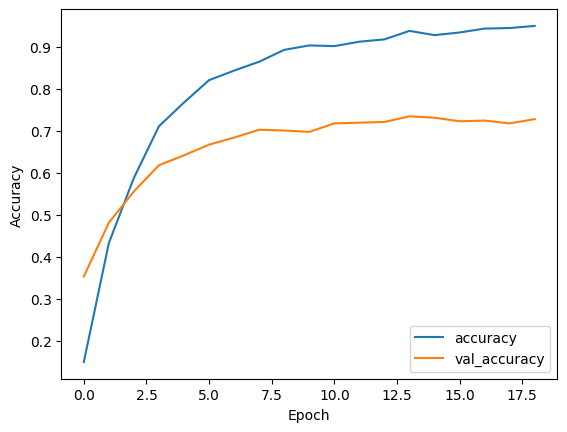

In [76]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

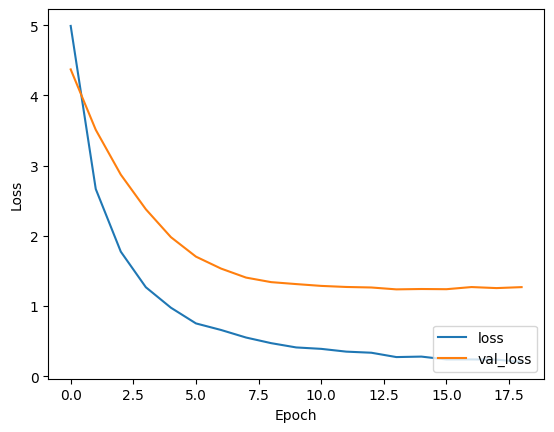

In [77]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

plt.show()

dict_keys(['accuracy', 'auc_2', 'loss', 'top_k_categorical_accuracy', 'val_accuracy', 'val_auc_2', 'val_loss', 'val_top_k_categorical_accuracy'])


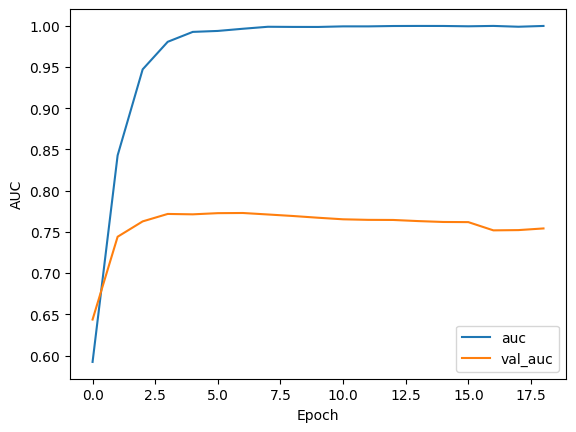

In [79]:
print(history.history.keys())
plt.plot(history.history['auc_2'], label='auc')
plt.plot(history.history['val_auc_2'], label = 'val_auc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')

plt.show()

In [32]:
# model = tf.keras.models.load_model("224x224 image classification EfficientNetB0 Train Split_.keras")

In [105]:
from skimage.transform import resize

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="uint8" )
    return data

img_needle = load_image("personal_test_images/space_needle_1.jpg")
img_chinatown = load_image("personal_test_images/Chinatown_gate.jpg")
img_library = load_image("personal_test_images/suzzalo.jpeg")
img_fountain = load_image("personal_test_images/fountain.jpg")

img_needle_resized = resize(np.array(img_needle), (224, 224, 3), anti_aliasing=True)
img_chinatown_resized = resize(np.array(img_chinatown), (224, 224, 3), anti_aliasing=True)
img_library_resized = resize(np.array(img_library), (224, 224, 3), anti_aliasing=True)
img_fountain_resized = resize(np.array(img_fountain), (224, 224, 3), anti_aliasing=True)

img_needle_resized = preprocess_input(img_needle_resized * 255).astype(int)
img_chinatown_resized = preprocess_input(img_chinatown_resized * 255).astype(int)
img_library_resized = preprocess_input(img_library_resized * 255).astype(int)
img_fountain_resized = preprocess_input(img_fountain_resized * 255).astype(int)

image_batch = np.array([img_needle_resized, img_chinatown_resized, img_library_resized, img_fountain_resized])

output = model.predict(image_batch)
output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


array([[8.59157637e-07, 5.95596433e-03, 1.41588828e-07, ...,
        5.81334064e-07, 1.34021207e-06, 7.83640246e-08],
       [3.16486403e-05, 6.53179231e-05, 1.82352858e-04, ...,
        2.04420667e-05, 5.18934503e-05, 2.38192850e-04],
       [5.87382871e-08, 8.23584571e-07, 6.10527366e-07, ...,
        1.04542295e-07, 9.67921005e-06, 3.74367687e-06],
       [8.91700040e-07, 2.78239509e-06, 7.01274475e-05, ...,
        1.40749398e-06, 3.60097852e-06, 8.56189217e-06]], dtype=float32)

In [106]:
classes = washington_data_cleaned['name'].unique()

for picture in output:
    guesses = np.argsort(picture)[-5:]
    print(np.round(picture[guesses][::-1], 3))

    for guess in guesses[::-1]:
        print(classes[guess])
        
    print("----------")

[0.988 0.006 0.003 0.002 0.001]
Dome Peak
Pier 55, Seattle, Washington
Museum of Glass
Union Station (Seattle)
Riverfront Park Carousel
----------
[0.244 0.207 0.086 0.05  0.048]
Rainier Tower
United Presbyterian Church (Pullman, Washington)
Manito Park
Cape Disappointment Lighthouse
Duwamish Head
----------
[0.998 0.001 0.    0.    0.   ]
Elbe Church, Washington
Pioneer Building (Seattle)
Point No Point Lighthouse
Comet Lodge Cemetery
Wedgwood Rock
----------
[0.971 0.005 0.004 0.002 0.002]
South Lake Union, Seattle, Washington
Tumwater Falls
Bothell Pioneer Cemetery
Victor Steinbrueck Park
Mount Shuksan
----------


# TEST IMAGE ONE
SPACE NEEDLE

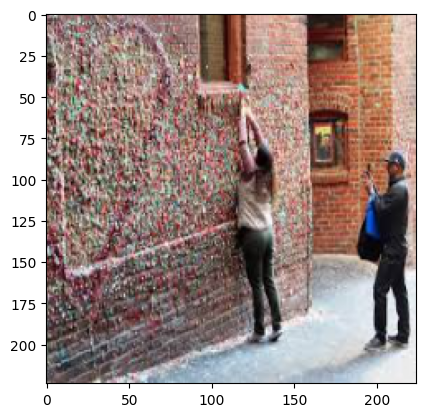

In [101]:
plt.imshow(img_needle_resized)

# TEST IMAGE TWO
INTERNATIONAL DISTRICT

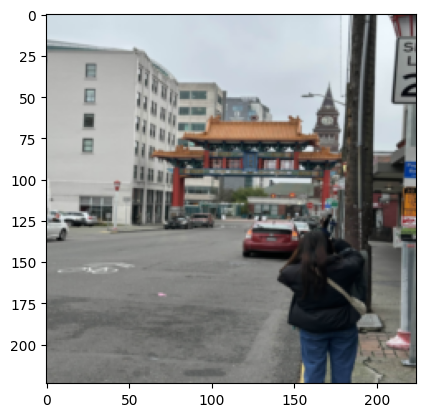

In [102]:
plt.imshow(img_chinatown_resized)

# TEST IMAGE THREE
SUZZALO LIBRARY (UW)

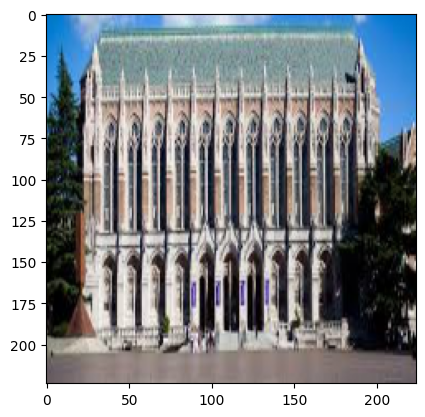

In [103]:
plt.imshow(img_library_resized)

# TEST IMAGE FOUR
Drumheller Fountain (UW)

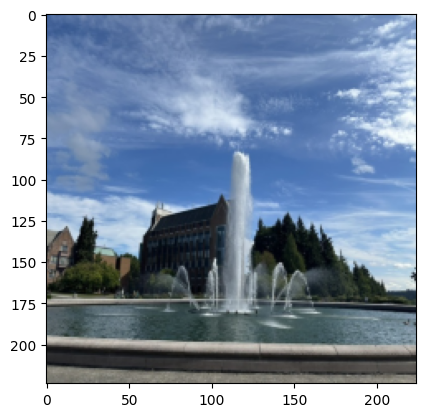

In [104]:
plt.imshow(img_fountain_resized)

# TESTING: 


In [93]:
test_output = model.predict(x_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 257ms/step


In [94]:
# x_test: numpy array of pixel values: 
# y_test: numpy array of one-hot encoded label
# test_output: array of arrays that contain probabilities for each label
index = 0 
num_correct = 0
for one_test_output in test_output: 
    guesses = np.argsort(one_test_output)[-5:]
    print(np.round(one_test_output[guesses][::-1], 3))
    actual_test_label_index = np.argmax(y_test[index])
    actual_label = classes[actual_test_label_index]
    print("ACTUAL LABEL: ", actual_label)
    prioritized_guesses = guesses[::-1]
    guess_labels = [1,1,1,1,1]
    for i in range(0,5):
        guess_labels[i] = classes[prioritized_guesses[i]]
        
    print("----------")
    print(guess_labels)
    print(guesses[::-1])
    if actual_label in guess_labels:
        num_correct += 1
    
    index +=1 
    
test_len = len(x_test)
print(num_correct)
print(num_correct/test_len)
    
# print(test_output[0])
# print(x_test[0])

[0.571 0.107 0.049 0.041 0.024]
ACTUAL LABEL:  Calhoun Hotel
----------
['Calhoun Hotel', 'Lake View Cemetery, Seattle', 'Wenas Wildlife Area', 'Seattle Times Building', 'Saltwater State Park']
[189  85 164  45 113]
[0.377 0.199 0.171 0.141 0.021]
ACTUAL LABEL:  North Head Lighthouse
----------
['North Head Lighthouse', 'Deception Pass', 'Astoria-Megler Bridge', 'Harvard Exit', 'Magnuson Park']
[260 118  74 153 103]
[0.694 0.214 0.076 0.003 0.002]
ACTUAL LABEL:  Pioneer Square, Seattle, Washington
----------
['Washington State University', 'Pioneer Square, Seattle, Washington', 'Drumheller Fountain', 'Saltwater State Park', 'Bellevue Downtown Park']
[170 220 289 113 165]
[0.992 0.001 0.001 0.001 0.001]
ACTUAL LABEL:  Nisqually Glacier
----------
['Nisqually Glacier', 'Henry M. Jackson Memorial Visitor Center', 'Swiftsure (ship, 1904)', 'Volunteer Park Conservatory', 'Bridge of the Gods']
[249 144 210 287 168]
[0.83  0.081 0.035 0.01  0.009]
ACTUAL LABEL:  Frank B. Cooper School
-------

'1611 Everett Avenue, Everett, Washington'